In [1]:
# %matplotlib inline
import os 
import argparse
import random
from main import train
random.seed()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #change to chosen GPU
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF


Using TensorFlow backend.


In [ ]:

parser = argparse.ArgumentParser(description='Train model')                                                                       
parser.add_argument('--generator', type=str, default="upsampling", help="upsampling or deconv or subpixel")    
parser.add_argument('--discriminator', type=str, default="discriminator", help="discriminator discriminator_resnet")
parser.add_argument('--dset', type=str, default="VisDA2017", help="mnistM or washington_vandal50k or washington_vandal12classes")             
parser.add_argument('--img_dim', default=64, type=int, help="Image width == height")                           
parser.add_argument('--nb_epoch', default=400, type=int, help="Number of epochs")                              
parser.add_argument('--batch_size', default=64, type=int, help='Batch size for training purpose; for testing is hardcoded at 32')                                   
parser.add_argument('--n_batch_per_epoch', default=1000, type=int, help="Number of batch per epochs")           
parser.add_argument('--bn_mode', default=2, type=int, help="Batch norm mode")                                  
parser.add_argument('--noise_dim', default=100, type=int, help="noise sampler dimension")                      
parser.add_argument('--noise_scale', default=0.5, type=float, help="noise sampler variance")                   
parser.add_argument('--disc_iterations', default=5, type=int, help="Number of discriminator iterations")         
parser.add_argument('--opt_D', type=str, default="Adam", help="Optimizer for the discriminator")            
parser.add_argument('--opt_G', type=str, default="Adam", help="Optimizer for the generator")  
parser.add_argument('--opt_rec', type=str, default="Adam", help="Optimizer for the recostruction model")
parser.add_argument('--lr_D', type=float, default=1E-4, help="learning rate for the discriminator")            
parser.add_argument('--lr_G', type=float, default=1-4, help="learning rate for the generator")  
parser.add_argument('--lr_rec', type=float, default=1-4, help="learning rate for the recostruction model")
parser.add_argument('--use_mbd', action="store_true", help="use mini batch disc")
parser.add_argument('--deterministic1', action="store_true", help="remove the noise input to GAN1")
parser.add_argument('--deterministic2', action="store_true", help="remove the noise input to GAN2")
parser.add_argument('--inject_noise', action="store_true", help="inject noise into each layer")
parser.add_argument('--model', type=str, default="lsgan", help="wgan or lsgan") 
parser.add_argument('--no_supertrain', action="store_true", help="no discriminator supertraining") 
parser.add_argument('--pureGAN', action="store_true", help="no discriminator supertraining")
parser.add_argument('--lsmooth', type=float, default=1.0, help="label smoothing")
parser.add_argument('--monsterClass', action="store_true", help="Discriminator with 2x classes")
parser.add_argument('--disc_type', type=str, default="simple_disc", help="Discriminator type,between simple_disc or nclass_disc")
parser.add_argument('--resume', action="store_true", help="load GAN weights from previous train")
parser.add_argument('--name', type=str, default="mnist_mnistM_SGD", help="name of the run, used for saving and loading weights")
parser.add_argument('--wd', type=float, default=0.0, help="weight decay for generator/discriminator")
parser.add_argument('--history_size', type=float, default=1.8, help="history pool size = history_size * batch_size")
parser.add_argument('--data_aug', action="store_true", help="perform data augmentation on target dataset")
parser.add_argument('--reconst_w', type=float, default=1.0, help="reconstruction weight")
parser.add_argument('--rec', action="store_true", help="activate reconstruction between Gen1 and Gen2")
parser.add_argument('--reconstClass', type=float, default=0.0, help="activate reconstructionClass and set its weight")
parser.add_argument('--class_weight', type=float, default=1.0, help="class_weight")
parser.add_argument('--pretrained', action="store_true", help="use resnet50 pretrained on Imagenet")
parser.add_argument('--cArch', type=str, default="google", help="name of classifier architecture, google or signs")                           


args = parser.parse_args(' --img_dim 28 --cArch google  --dset usps_to_mnist --model lsgan --history_size 1.5 --no_supertrain \
                          --disc_type nclass_disc --class_weight 1.0 --opt_D Adam --opt_G Adam\
                           --reconstClass 1.0 --batch_size 32 --disc_iterations 1 --wd 1E-4 --lr_D 1E-3 --lr_G 1E-3'.split())
######
print (args)

assert args.opt_G in ["RMSprop", "SGD", "Adam"], "Unsupported optimizer"                 
assert args.opt_D in ["RMSprop", "SGD", "Adam"], "Unsupported optimizer" 

# Set the backend by modifying the env variable                                                                
                                                                            
os.environ["KERAS_BACKEND"] = "tensorflow"  
import keras.backend as K                                                                           
image_dim_ordering = "tf"                                                                                  
K.set_image_dim_ordering(image_dim_ordering)

# Set default params
d_params = {"generator": args.generator,
            "discriminator": args.discriminator,
            "dset": args.dset,
            "img_dim": args.img_dim,
            "nb_epoch": args.nb_epoch,
            "batch_size": args.batch_size,
            "n_batch_per_epoch": args.n_batch_per_epoch,
            "bn_mode": args.bn_mode,
            "noise_dim": args.noise_dim,
            "noise_scale": args.noise_scale,
            "disc_iterations": args.disc_iterations,
            "lr_D": args.lr_D,
            "lr_G": args.lr_G,
            "lr_rec": args.lr_rec,
            "opt_rec": args.opt_rec,
            "opt_D": args.opt_D,
            "opt_G": args.opt_G,
            "use_mbd": args.use_mbd,
            "deterministic1": args.deterministic1,
            "deterministic2": args.deterministic2,
            "pureGAN": args.pureGAN,
            "lsmooth": args.lsmooth,
            "image_dim_ordering": image_dim_ordering,
            "model": args.model,
            "no_supertrain": args.no_supertrain,
            "monsterClass": args.monsterClass,
            "data_aug": args.data_aug,
            "disc_type": args.disc_type,
            "resume": args.resume,
            "name": args.name,
            "inject_noise": args.inject_noise,
            "history_size" : args.history_size,
            "reconst_w" : args.reconst_w,
            "class_weight" : args.class_weight,
            "rec" : args.rec,
            "reconstClass" : args.reconstClass,
            "pretrained" : args.pretrained,
            "cArch" : args.cArch,
            "wd" : args.wd
            }


Namespace(batch_size=32, bn_mode=2, cArch='google', class_weight=1.0, data_aug=False, deterministic1=False, deterministic2=False, disc_iterations=1, disc_type='nclass_disc', discriminator='discriminator', dset='usps_to_mnist', generator='upsampling', history_size=1.5, img_dim=28, inject_noise=False, lr_D=0.001, lr_G=0.001, lr_rec=-3, lsmooth=1.0, model='lsgan', monsterClass=False, n_batch_per_epoch=1000, name='mnist_mnistM_SGD', nb_epoch=400, no_supertrain=True, noise_dim=100, noise_scale=0.5, opt_D='Adam', opt_G='Adam', opt_rec='Adam', pretrained=False, pureGAN=False, rec=False, reconstClass=1.0, reconst_w=1.0, resume=False, use_mbd=False, wd=0.0001)



Experiment parameters:
generator upsampling
discriminator discriminator
dset usps_to_mnist
img_dim 28
nb_epoch 400
batch_size 32
n_batch_per_epoch 1000
bn_mode 2
noise_dim 100
noise_scale 0.5
disc_iterations 1
lr_D 0.001
lr_G 0.001
lr_rec -3
opt_rec Adam
opt_D Adam
opt_G Adam
use_mbd False
deterministic1 False
deterministic2 False
pureGAN False
lsmooth 1.0
image_dim_ordering tf
model lsgan
no_supertrain True
monsterClass False
data_aug False
disc_type nclass_disc
resume False
name mnist_mnistM_SGD
inject_noise False
history_size 1.5
reconst_w 1.0
class_weight 1.0
rec False
reconstClass 1.0
pretrained False
cArch google
wd 0.0001




/data/R_codes/SBADAGAN/models.py:77: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3920, input_dim=(100,), kernel_regularizer=<keras.reg...)`
  x = Dense(5*s*s, input_dim=noise_dim,W_regularizer=l2(wd))(gen_noise_input)
/data/R_codes/SBADAGAN/models.py:86: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  g = merge([gen_image_input, x], mode='concat',concat_axis=3) # because of concat_axis=1, will it work on tensorflow NHWC too?
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/data/R_codes/SBADAGAN/models.py:88: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", kernel_regularizer=<keras.reg...)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_input (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3920)         395920      generator_input[0][0]            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 5)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
generator_image_input (InputLay (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
activation

/data/R_codes/SBADAGAN/models.py:139: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3920, input_dim=(100,), kernel_regularizer=<keras.reg...)`
  x = Dense(5*s*s, input_dim=noise_dim,W_regularizer=l2(wd))(gen_noise_input)
/data/R_codes/SBADAGAN/models.py:148: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  g = merge([gen_image_input, x], mode='concat',concat_axis=3) # because of concat_axis=1, will it work on tensorflow NHWC too?
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/data/R_codes/SBADAGAN/models.py:150: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", kernel_regularizer=<keras.reg.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_input (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3920)         395920      generator_input[0][0]            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 5)    0           dense_2[0][0]                    
__________________________________________________________________________________________________
generator_image_input (InputLay (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
activation

/data/R_codes/SBADAGAN/models.py:245: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), name="disc_conv2d_1", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
/data/R_codes/SBADAGAN/models.py:251: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2), name="disc_conv2d_2", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:256: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), strides=(1, 1), name="finale_conv", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regul

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
disc_conv2d_1 (Conv2D)       (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        56        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
disc_conv2d_2 (Conv2D)       (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         28        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
__________

/data/R_codes/SBADAGAN/models.py:279: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), name="disc_conv2d_1", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
/data/R_codes/SBADAGAN/models.py:285: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2), name="disc_conv2d_2", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:290: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), strides=(1, 1), name="finale_conv", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regul

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
disc_conv2d_1 (Conv2D)          (None, 14, 14, 64)   640         discriminator_input[0][0]        
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 14, 14, 64)   56          disc_conv2d_1[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 14, 14, 64)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
disc_conv2

/data/R_codes/SBADAGAN/models.py:334: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), name="conv1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(32, (5, 5), strides=(1, 1), name="conv1",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(input)
/data/R_codes/SBADAGAN/models.py:337: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(1, 1), name="conv2", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(48, (5, 5), strides=(1, 1), name="conv2",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:341: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fc1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  x = Dense(100, init="he_normal",activation="relu", name='f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 48)        38448     
_________________________________________________________________
activation_24 (Activation)   (None, 14, 14, 48)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 48)          0         
__________

/data/R_codes/SBADAGAN/models.py:334: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), name="conv1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(32, (5, 5), strides=(1, 1), name="conv1",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(input)
/data/R_codes/SBADAGAN/models.py:337: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(1, 1), name="conv2", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(48, (5, 5), strides=(1, 1), name="conv2",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:341: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fc1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  x = Dense(100, init="he_normal",activation="relu", name='f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_25 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 48)        38448     
_________________________________________________________________
activation_26 (Activation)   (None, 14, 14, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 48)          0         
__________

/data/R_codes/SBADAGAN/models.py:494: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("di...)`
  output=DCGAN_output)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
generator_google1 (Model)       (None, 28, 28, 1)    695825      noise_input[0][0]                
                                                                 image_input[0][0]                
__________________________________________________________________________________________________
discriminator_domain (Model)    (None, 1)            75733       generator_google1[1][0]          
Total para

/data/R_codes/SBADAGAN/models.py:515: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("cl...)`
  output=DCGAN_output)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
generator_google1 (Model)       (None, 28, 28, 1)    695825      noise_input[0][0]                
                                                                 image_input[0][0]                
__________________________________________________________________________________________________
classifier (Model)              (None, 10)           285690      generator_google1[2][0]          
Total para

/data/R_codes/SBADAGAN/models.py:538: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="DCGAN", inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  name="DCGAN")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
generator_google1 (Model)       (None, 28, 28, 1)    695825      noise_input[0][0]                
                                                                 image_input[0][0]                
__________________________________________________________________________________________________
discriminator (Model)           [(None, 1), (None, 1 138463      generator_google1[1][0]          
Total para

/data/R_codes/SBADAGAN/additional_models.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="zClass", inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  zclass_model = Model(input=[generator.layers[0].input,image_input],output=[x],name="zClass")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3920)              395920    
_________________________________________________________________
fc3 (Dense)                  (None, 100)               392100    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
fc4 (Dense)                  (None, 100)               10100     
Total params: 798,120
Trainable params: 798,120
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Pretrain of discriminator finished.
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0094 - Loss_D_gen1: 0.0095 - Loss_G1: 0.0460 - Loss_Classifier1: 0.0219 - Loss_Rec1: 0.0493 - Loss_GenClass1: 0.0643

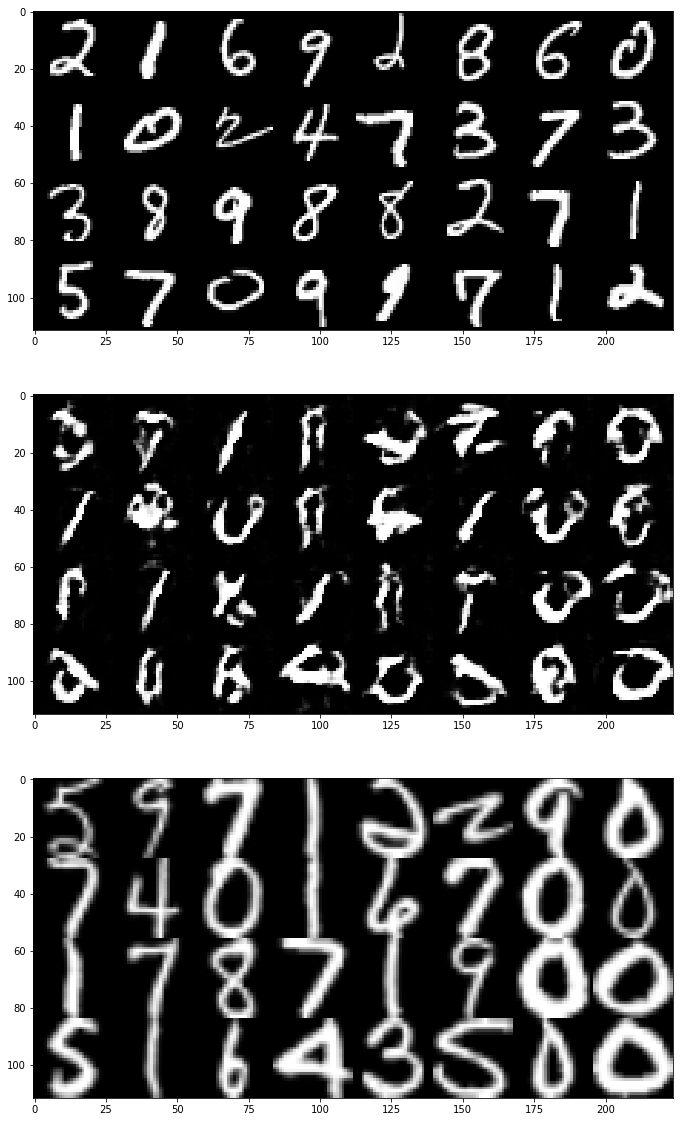

Dest labels:
[2 1 6 9 2 8 6 0 1 0 2 4 7 3 7 3 3 8 9 8 8 2 7 1 5 7 0 9 9 7 1 2]
Source labels:
[5 9 7 1 2 2 9 0 7 4 0 1 6 7 0 0 1 7 8 7 1 9 0 0 5 1 6 4 3 5 0 0]

Epoch 2, Time: 183.57563757896423
epoch 1, Saved weights!
10000/10000 [==============================] - 1s 93us/step

 Classifier Accuracy and loss on full target domain:  32.60%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  40.27%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0116 - Loss_D_gen1: 0.0113 - Loss_G1: 0.0448 - Loss_Classifier1: 0.0149 - Loss_Rec1: 0.0230 - Loss_GenClass1: 0.0477

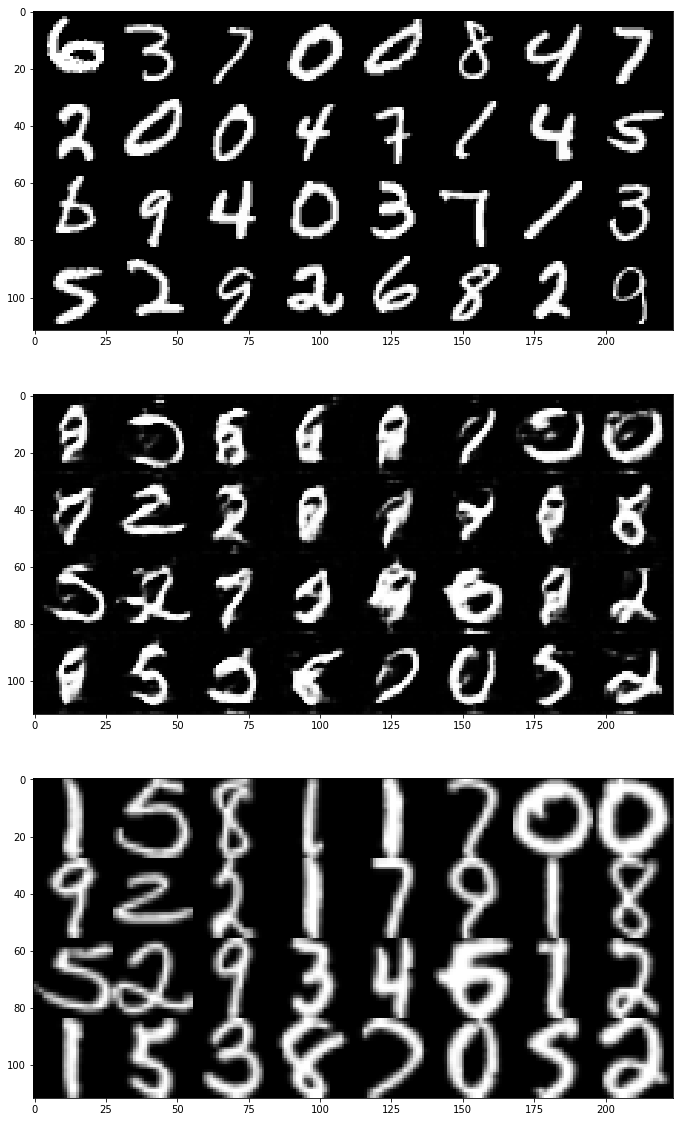

Dest labels:
[6 3 7 0 0 8 4 7 2 0 0 4 7 1 4 5 6 9 4 0 3 7 1 3 5 2 9 2 6 8 2 9]
Source labels:
[1 5 8 1 1 7 0 0 9 2 2 1 7 9 1 8 5 2 9 3 4 6 1 2 1 5 3 8 7 0 5 2]

Epoch 3, Time: 184.01140666007996
epoch 2, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  48.60%  
10000/10000 [==============================] - 0s 31us/step

 Classifier Accuracy and loss on full target domain:  53.16%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0117 - Loss_D_gen1: 0.0115 - Loss_G1: 0.0439 - Loss_Classifier1: 0.0123 - Loss_Rec1: 0.0176 - Loss_GenClass1: 0.0430

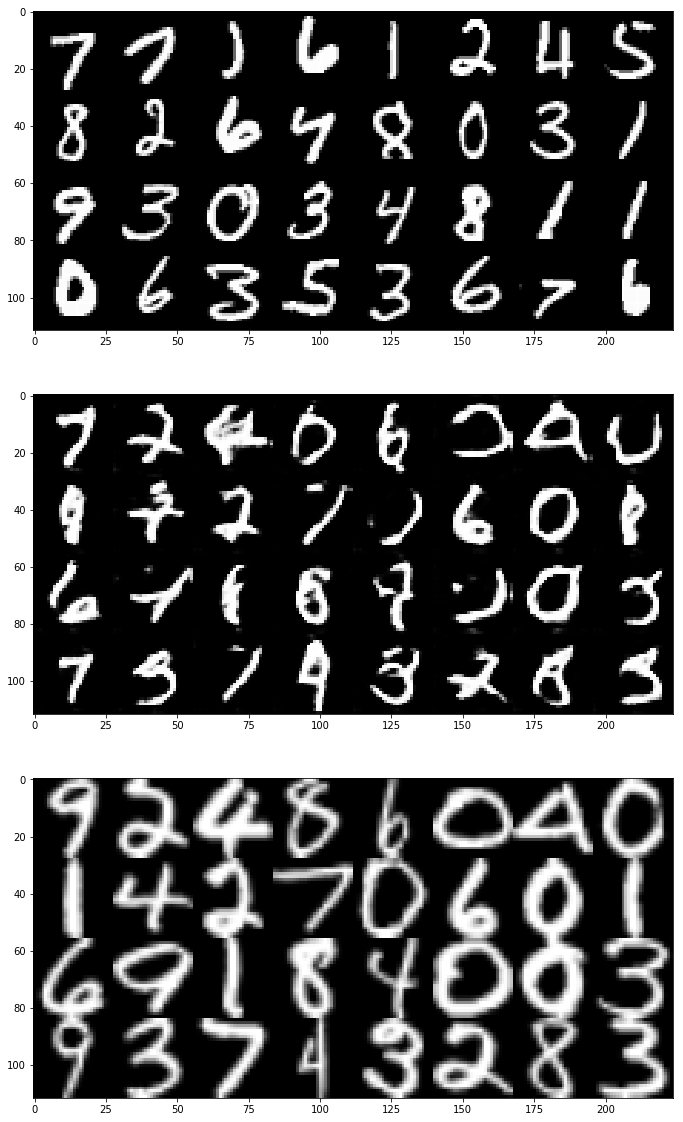

Dest labels:
[7 7 1 6 1 2 4 5 8 2 6 4 8 0 3 1 9 3 0 3 4 8 1 1 0 6 3 5 3 6 7 6]
Source labels:
[9 2 4 8 6 0 4 0 1 4 2 7 0 6 0 1 6 9 1 8 4 0 0 3 9 3 7 4 3 2 8 3]

Epoch 4, Time: 182.65308260917664
epoch 3, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  52.98%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  58.01%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0121 - Loss_D_gen1: 0.0121 - Loss_G1: 0.0434 - Loss_Classifier1: 0.0116 - Loss_Rec1: 0.0153 - Loss_GenClass1: 0.0407

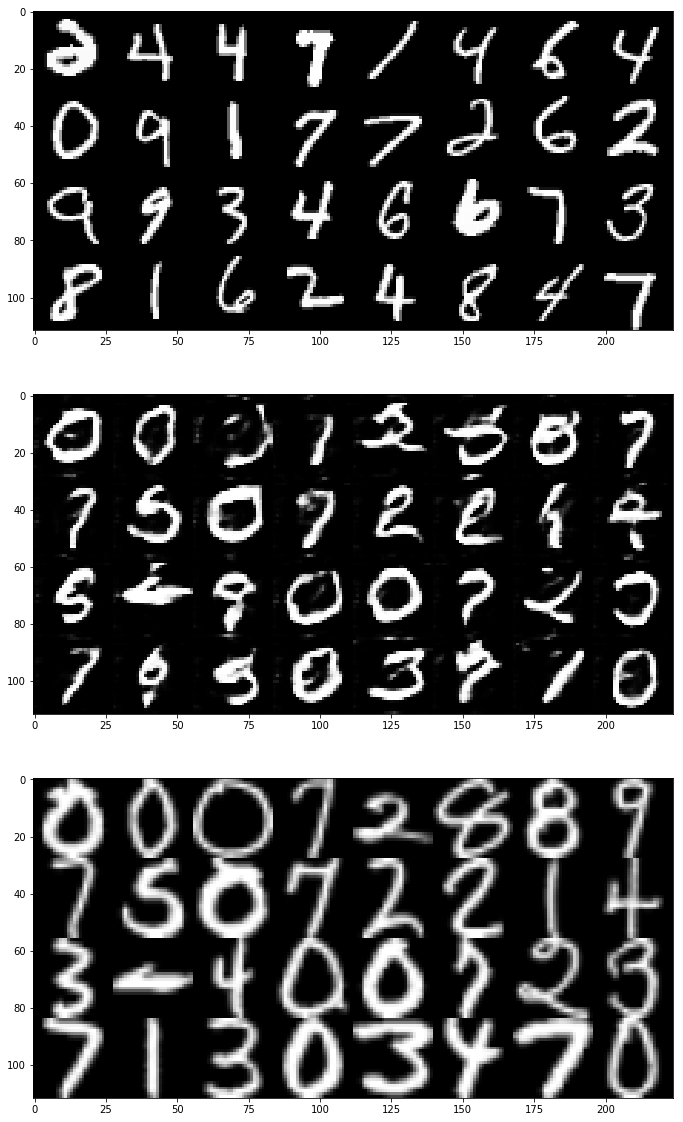

Dest labels:
[2 4 4 7 1 4 6 4 0 9 1 7 7 2 6 2 9 9 3 4 6 6 7 3 8 1 6 2 4 8 4 7]
Source labels:
[0 0 0 7 2 8 8 9 7 5 0 7 2 2 1 4 3 2 4 0 0 7 2 3 7 1 3 0 3 4 7 0]

Epoch 5, Time: 190.6607940196991
epoch 4, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  56.60%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  58.69%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0115 - Loss_D_gen1: 0.0113 - Loss_G1: 0.0444 - Loss_Classifier1: 0.0102 - Loss_Rec1: 0.0133 - Loss_GenClass1: 0.0394

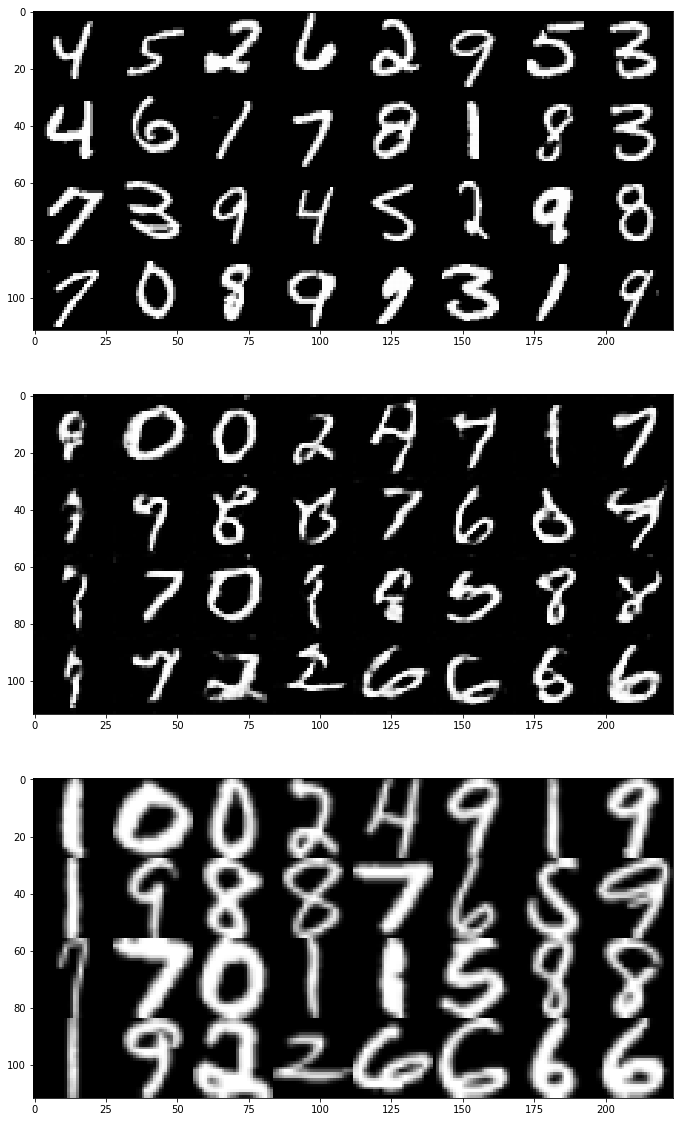

Dest labels:
[4 5 2 6 2 9 5 3 4 6 1 7 8 1 8 3 7 3 9 4 5 2 9 8 7 0 8 9 9 3 1 9]
Source labels:
[1 0 0 2 4 9 1 9 1 9 8 8 7 6 5 9 7 7 0 1 1 5 8 8 1 9 2 2 6 6 6 6]

Epoch 6, Time: 186.5504491329193
epoch 5, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  56.83%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  61.55%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0120 - Loss_D_gen1: 0.0118 - Loss_G1: 0.0438 - Loss_Classifier1: 0.0096 - Loss_Rec1: 0.0120 - Loss_GenClass1: 0.0343

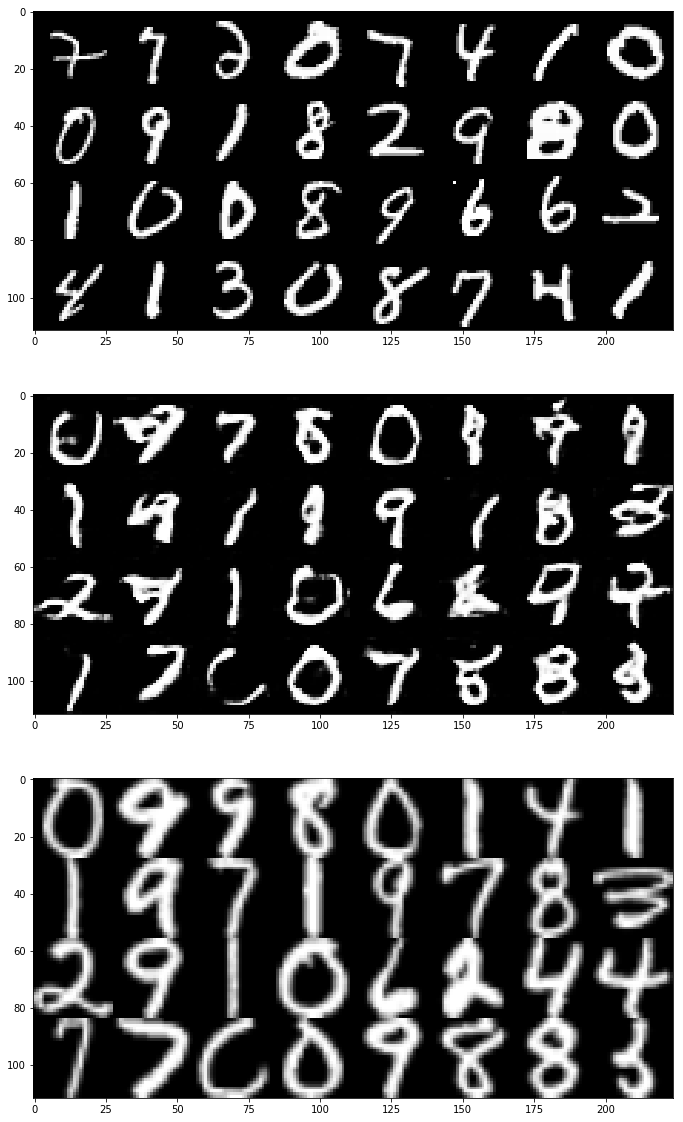

Dest labels:
[7 7 2 0 7 4 1 0 0 9 1 8 2 9 8 0 1 0 0 8 9 6 6 2 4 1 3 0 8 7 4 1]
Source labels:
[0 9 9 8 0 1 4 1 1 9 7 1 9 7 8 3 2 9 1 0 6 2 4 4 7 7 0 0 9 8 8 5]

Epoch 7, Time: 185.59478092193604
epoch 6, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  61.05%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  61.94%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0125 - Loss_D_gen1: 0.0124 - Loss_G1: 0.0398 - Loss_Classifier1: 0.0091 - Loss_Rec1: 0.0108 - Loss_GenClass1: 0.0289

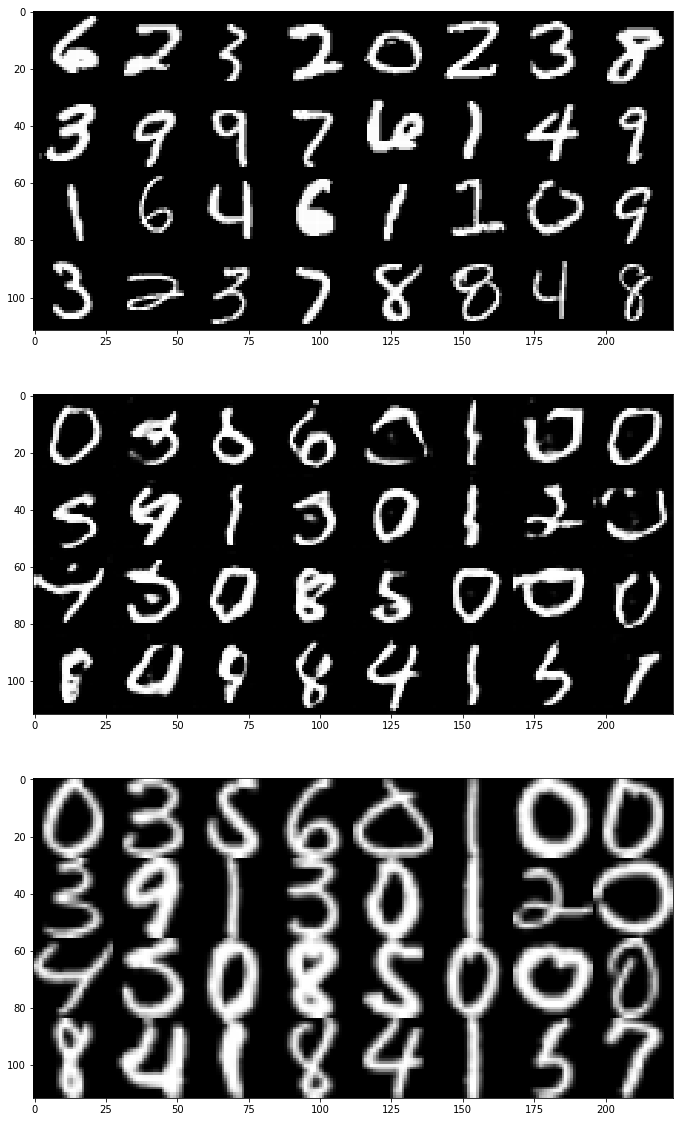

Dest labels:
[6 2 3 2 0 2 3 8 3 9 9 7 6 1 4 9 1 6 4 6 1 1 0 9 3 2 3 7 8 8 4 8]
Source labels:
[0 3 5 6 0 1 0 0 3 9 1 3 0 1 2 0 4 5 0 8 5 0 0 0 8 4 1 8 4 1 5 7]

Epoch 8, Time: 183.08957266807556
epoch 7, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  61.78%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  63.82%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0129 - Loss_D_gen1: 0.0127 - Loss_G1: 0.0365 - Loss_Classifier1: 0.0086 - Loss_Rec1: 0.0098 - Loss_GenClass1: 0.0245

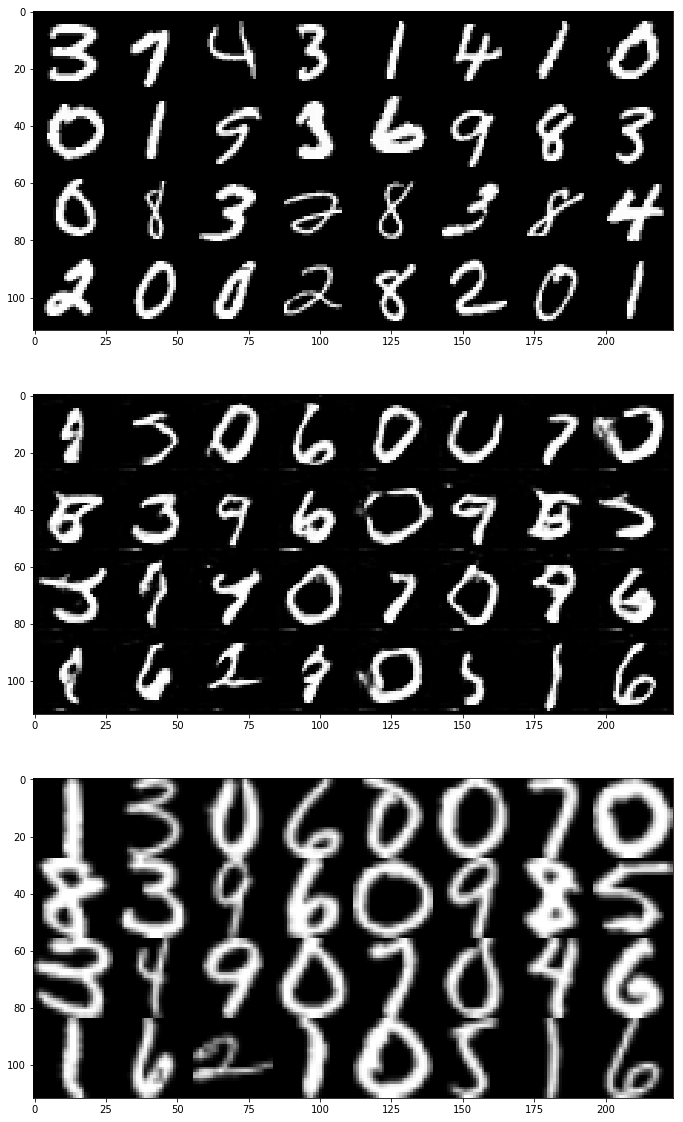

Dest labels:
[3 7 4 3 1 4 1 0 0 1 9 3 6 9 8 3 0 8 3 2 8 3 8 4 2 0 0 2 8 2 0 1]
Source labels:
[1 3 0 6 0 0 7 0 8 3 9 6 0 9 8 5 3 4 9 0 7 0 4 6 1 6 2 1 0 5 1 6]

Epoch 9, Time: 182.97568321228027
epoch 8, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  61.68%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  61.07%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0132 - Loss_D_gen1: 0.0130 - Loss_G1: 0.0337 - Loss_Classifier1: 0.0084 - Loss_Rec1: 0.0093 - Loss_GenClass1: 0.0222

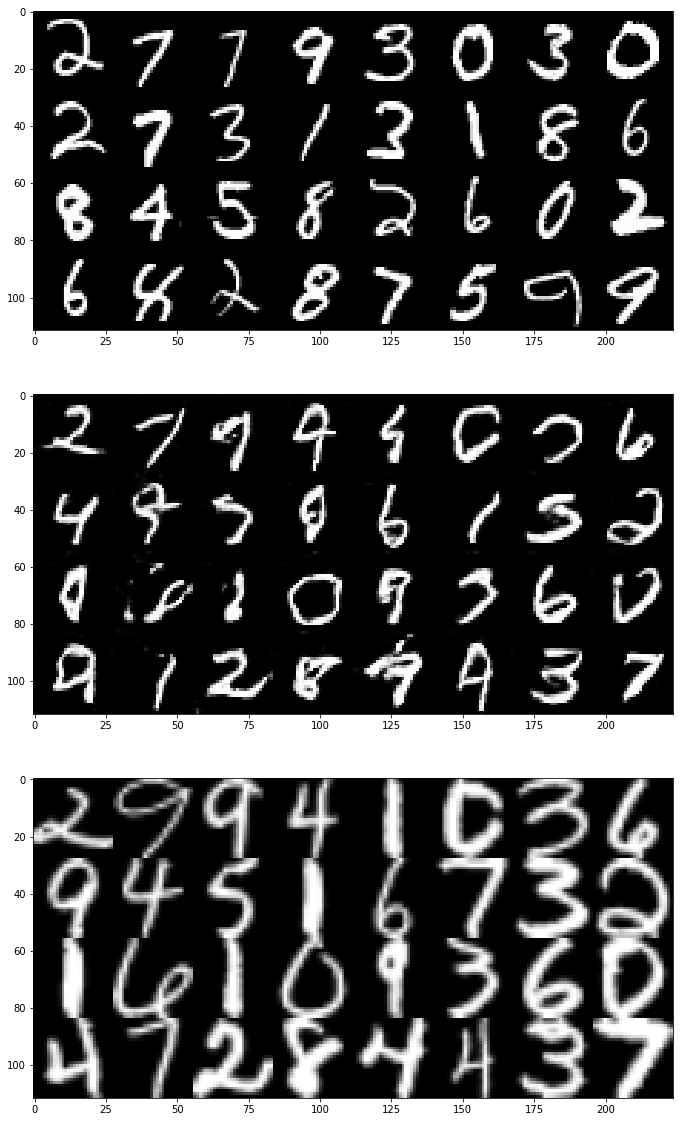

Dest labels:
[2 7 7 9 3 0 3 0 2 7 3 1 3 1 8 6 8 4 5 8 2 6 0 2 6 8 2 8 7 5 9 9]
Source labels:
[2 9 9 4 1 0 3 6 9 4 5 1 6 7 3 2 1 6 1 0 9 3 6 0 4 7 2 8 4 4 3 7]

Epoch 10, Time: 182.62479305267334
epoch 9, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  61.67%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  63.80%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0135 - Loss_D_gen1: 0.0134 - Loss_G1: 0.0315 - Loss_Classifier1: 0.0079 - Loss_Rec1: 0.0089 - Loss_GenClass1: 0.0203

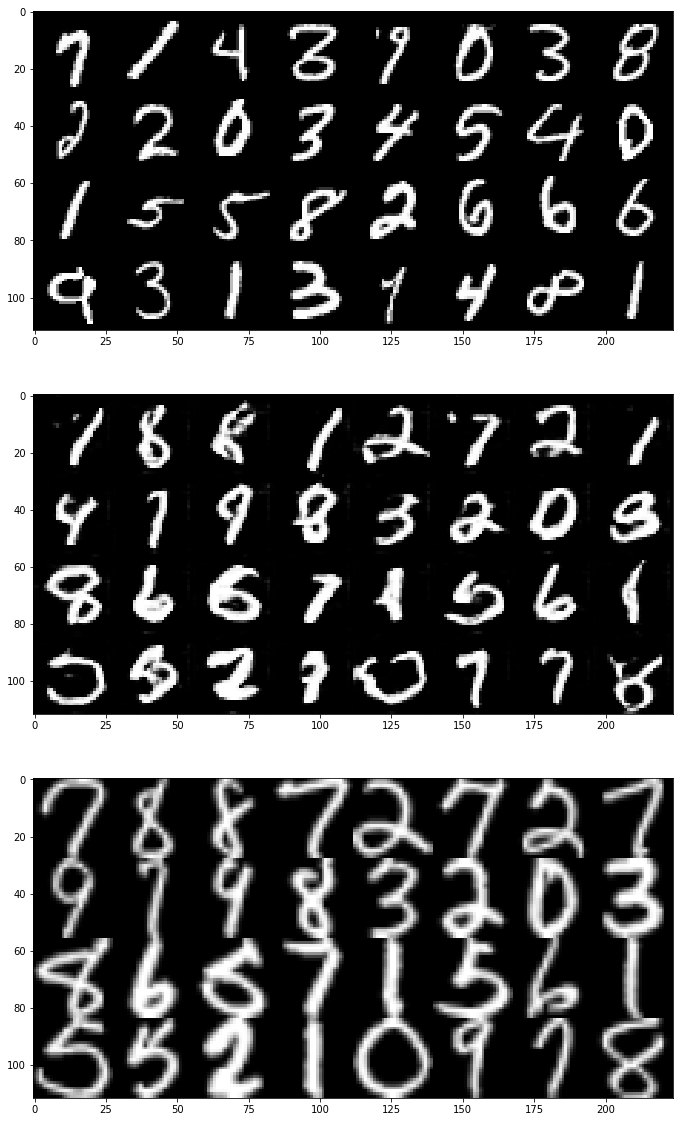

Dest labels:
[7 1 4 3 9 0 3 8 2 2 0 3 4 5 4 0 1 5 5 8 2 6 6 6 9 3 1 3 1 4 8 1]
Source labels:
[7 8 8 7 2 7 2 7 9 7 9 8 3 2 0 3 8 6 5 7 1 5 6 1 5 5 2 1 0 9 7 8]

Epoch 11, Time: 181.52560186386108
epoch 10, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  64.39%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  66.72%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0138 - Loss_D_gen1: 0.0136 - Loss_G1: 0.0290 - Loss_Classifier1: 0.0077 - Loss_Rec1: 0.0085 - Loss_GenClass1: 0.0189

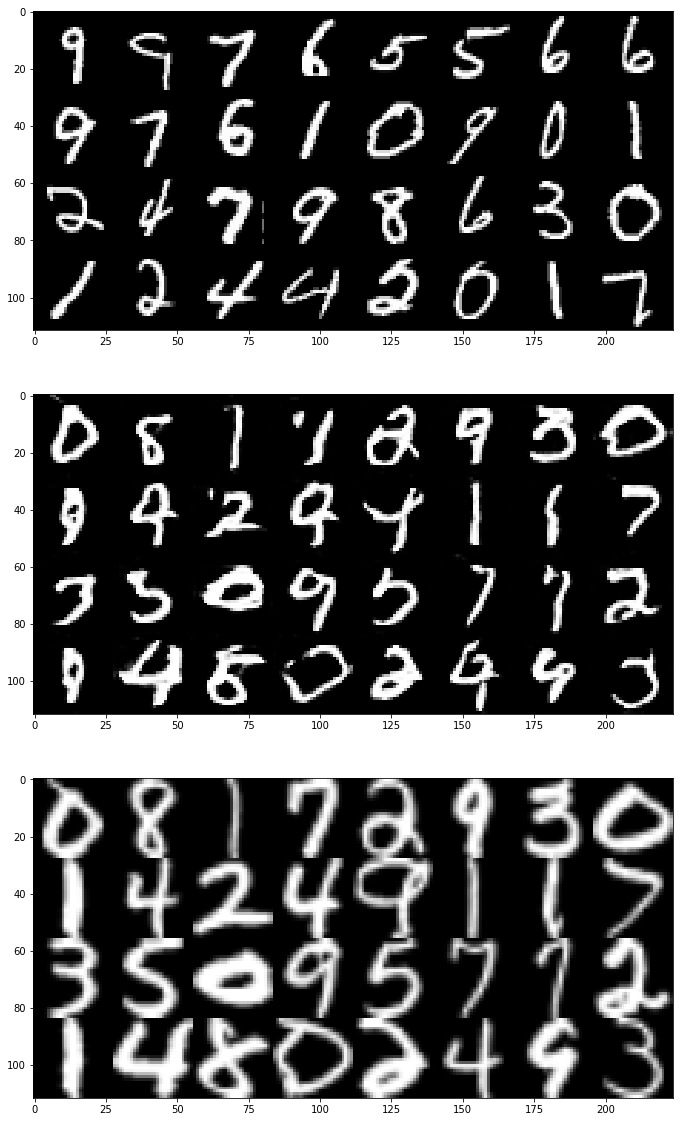

Dest labels:
[9 9 7 6 5 5 6 6 9 7 6 1 0 9 0 1 2 4 7 9 8 6 3 0 1 2 4 4 2 0 1 7]
Source labels:
[0 8 1 7 2 9 3 0 1 4 2 4 9 1 1 7 3 5 0 9 5 7 7 2 1 4 8 0 2 4 9 3]

Epoch 12, Time: 182.6879177093506
epoch 11, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  63.93%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  65.32%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0140 - Loss_D_gen1: 0.0138 - Loss_G1: 0.0265 - Loss_Classifier1: 0.0073 - Loss_Rec1: 0.0081 - Loss_GenClass1: 0.0169

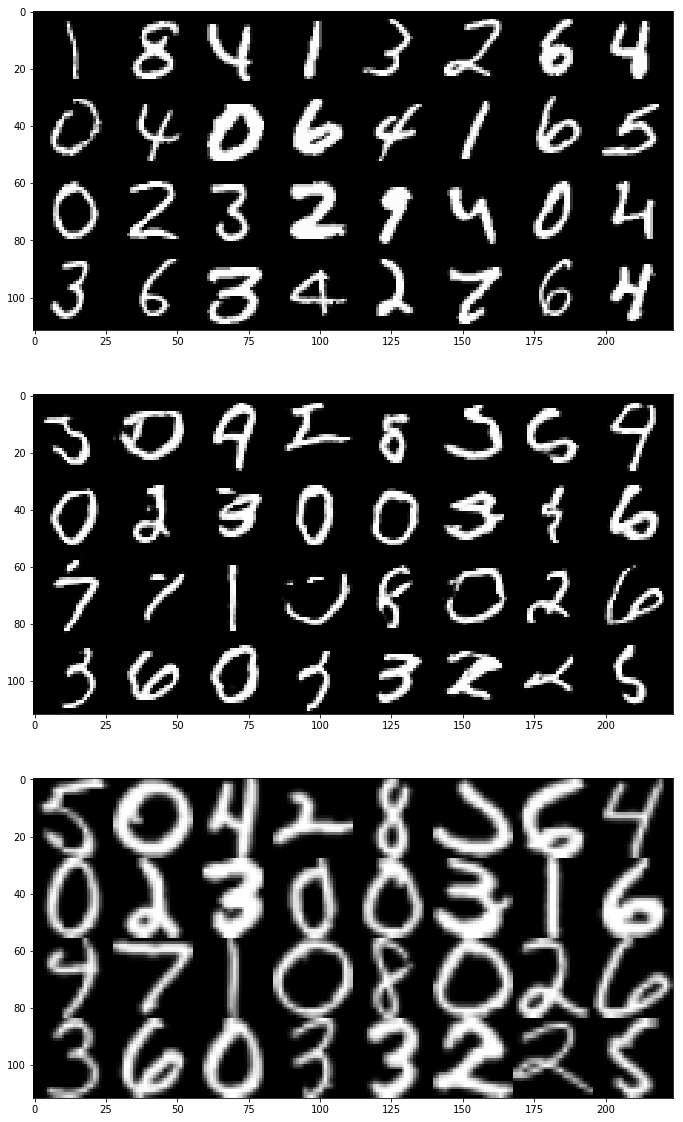

Dest labels:
[1 8 4 1 3 2 6 4 0 4 0 6 4 1 6 5 0 2 3 2 9 4 0 4 3 6 3 4 2 7 6 4]
Source labels:
[5 0 4 2 8 5 6 4 0 2 3 0 0 3 1 6 4 7 1 0 8 0 2 6 3 6 0 3 3 2 2 5]

Epoch 13, Time: 183.6122407913208
epoch 12, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  66.96%  
10000/10000 [==============================] - 0s 31us/step

 Classifier Accuracy and loss on full target domain:  65.91%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0139 - Loss_D_gen1: 0.0138 - Loss_G1: 0.0249 - Loss_Classifier1: 0.0073 - Loss_Rec1: 0.0080 - Loss_GenClass1: 0.0163

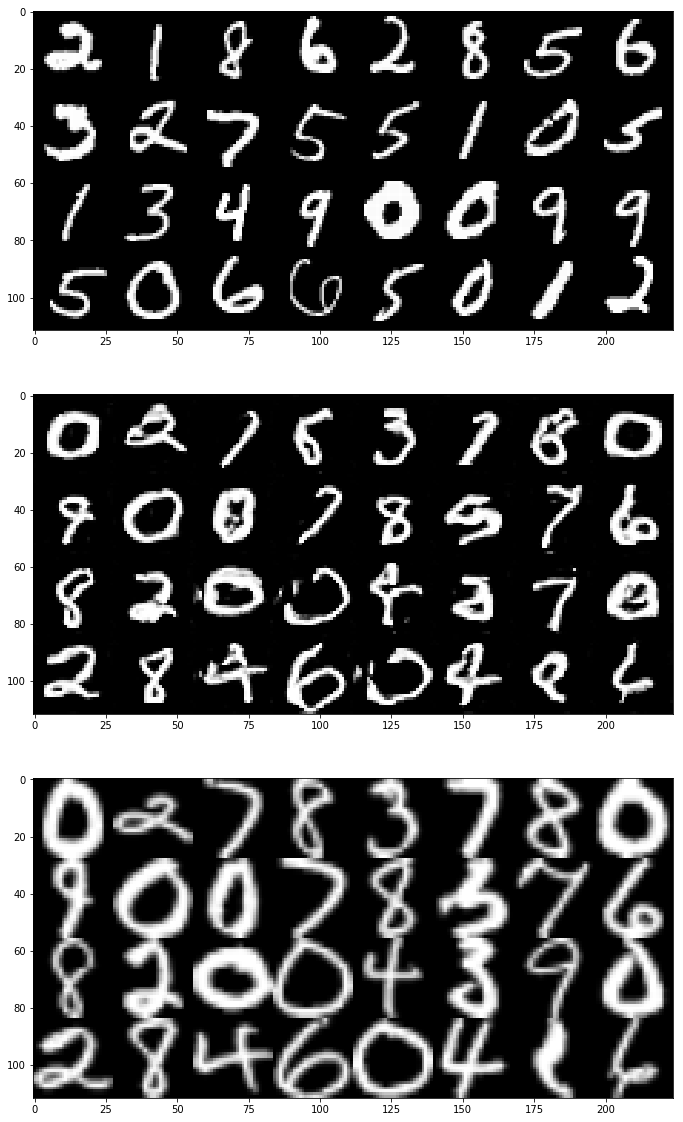

Dest labels:
[2 1 8 6 2 8 5 6 3 2 7 5 5 1 0 5 1 3 4 9 0 0 9 9 5 0 6 6 5 0 1 2]
Source labels:
[0 2 7 8 3 7 8 0 9 0 0 7 8 5 7 6 8 2 0 0 4 3 9 0 2 8 4 6 0 4 1 6]

Epoch 14, Time: 188.0249102115631
epoch 13, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  67.62%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  67.68%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0140 - Loss_D_gen1: 0.0138 - Loss_G1: 0.0229 - Loss_Classifier1: 0.0069 - Loss_Rec1: 0.0075 - Loss_GenClass1: 0.0145

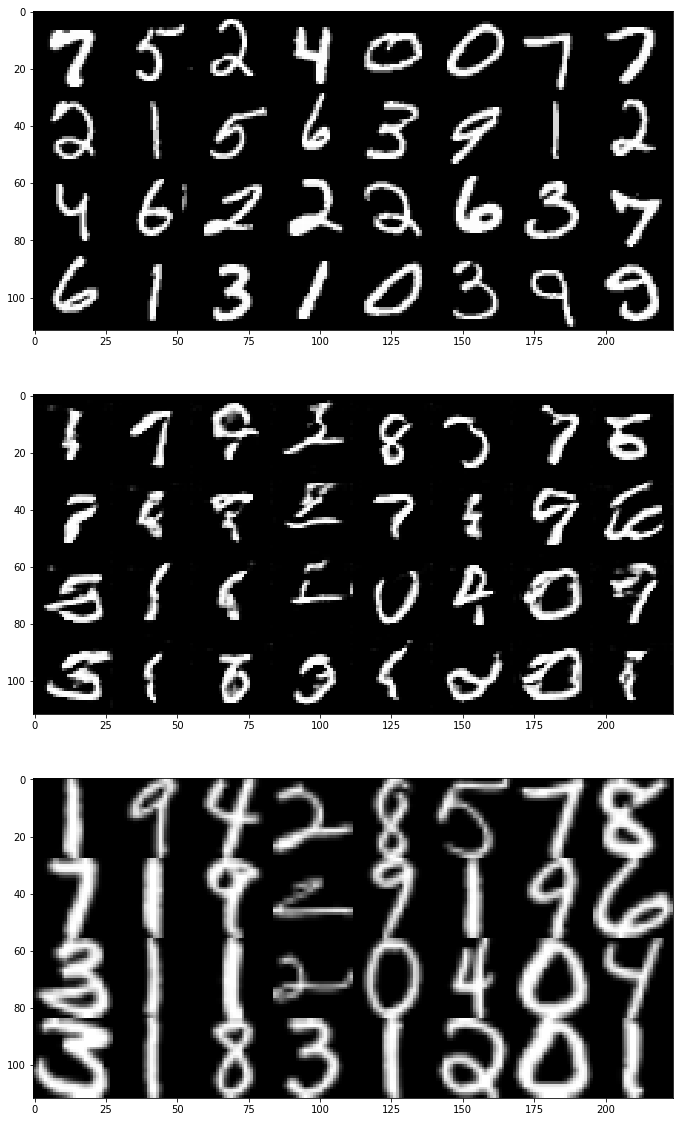

Dest labels:
[7 5 2 4 0 0 7 7 2 1 5 6 3 9 1 2 4 6 2 2 2 6 3 7 6 1 3 1 0 3 9 9]
Source labels:
[1 9 4 2 8 5 7 8 7 1 9 2 9 1 9 6 3 1 1 2 0 4 0 4 3 1 8 3 1 2 0 1]

Epoch 15, Time: 181.66799569129944
epoch 14, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  70.93%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  69.78%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0138 - Loss_D_gen1: 0.0137 - Loss_G1: 0.0217 - Loss_Classifier1: 0.0068 - Loss_Rec1: 0.0074 - Loss_GenClass1: 0.0138

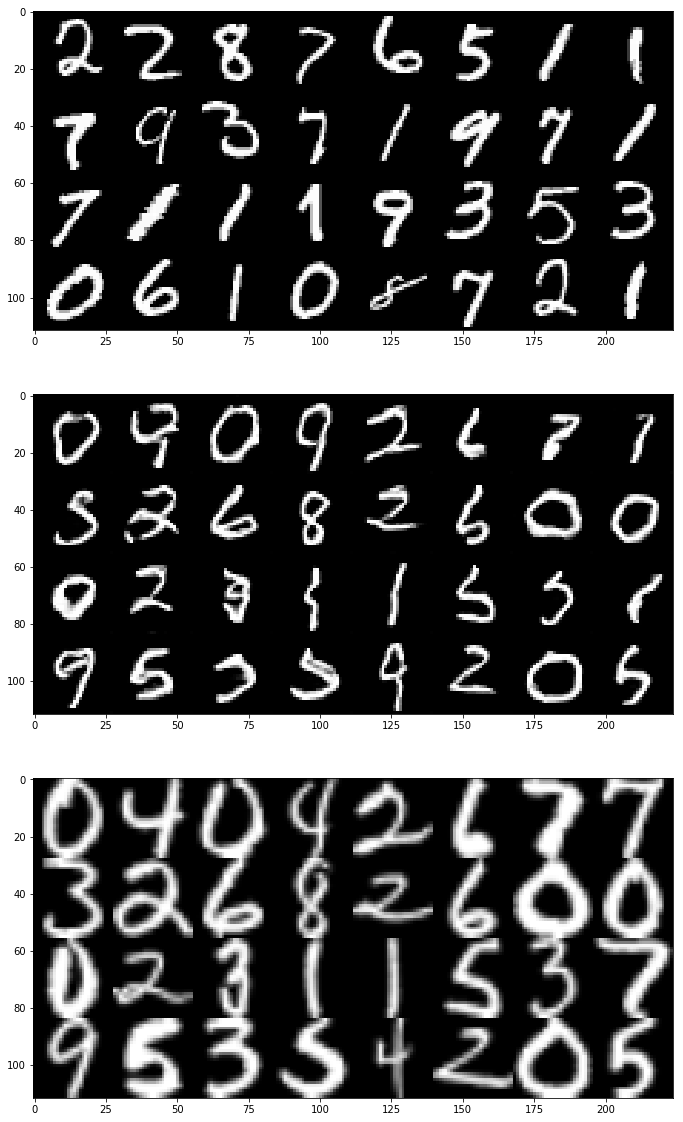

Dest labels:
[2 2 8 7 6 5 1 1 7 9 3 7 1 9 7 1 7 1 1 1 9 3 5 3 0 6 1 0 8 7 2 1]
Source labels:
[0 4 0 4 2 6 7 7 3 2 6 8 2 6 0 0 0 2 3 1 1 5 3 7 9 5 3 5 4 2 0 5]

Epoch 16, Time: 181.321147441864
epoch 15, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  70.11%  
10000/10000 [==============================] - 0s 28us/step

 Classifier Accuracy and loss on full target domain:  69.30%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0137 - Loss_D_gen1: 0.0136 - Loss_G1: 0.0209 - Loss_Classifier1: 0.0069 - Loss_Rec1: 0.0073 - Loss_GenClass1: 0.0132

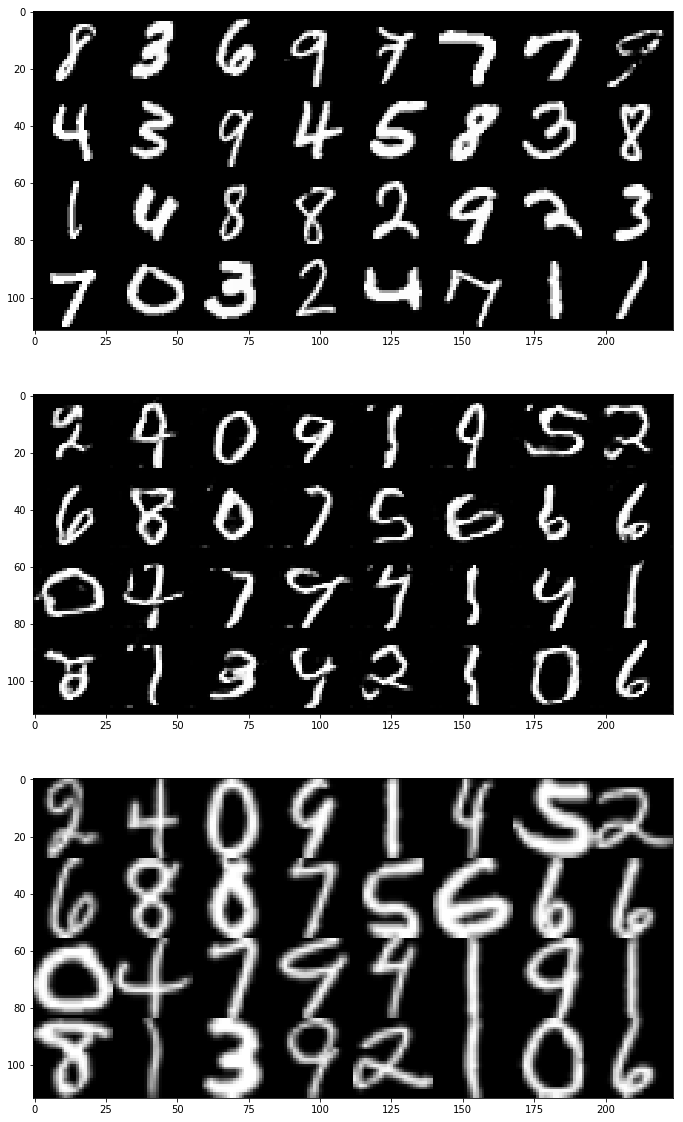

Dest labels:
[8 3 6 9 7 7 7 9 4 3 9 4 5 8 3 8 1 4 8 8 2 9 2 3 7 0 3 2 4 7 1 1]
Source labels:
[2 4 0 9 1 4 5 2 6 8 0 7 5 6 6 6 0 4 7 9 4 1 9 1 8 1 3 9 2 1 0 6]

Epoch 17, Time: 185.65182971954346
epoch 16, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  71.58%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  71.19%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0136 - Loss_D_gen1: 0.0135 - Loss_G1: 0.0200 - Loss_Classifier1: 0.0070 - Loss_Rec1: 0.0072 - Loss_GenClass1: 0.0126

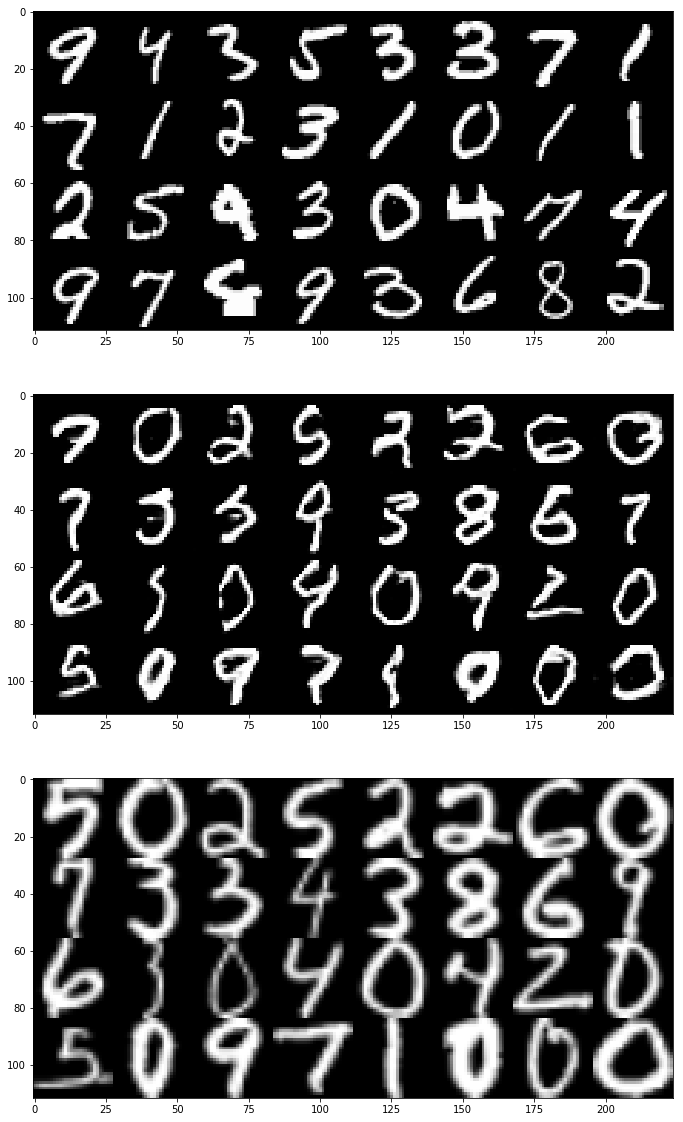

Dest labels:
[9 4 3 5 3 3 7 1 7 1 2 3 1 0 1 1 2 5 9 3 0 4 7 4 9 7 8 9 3 6 8 2]
Source labels:
[5 0 2 5 2 2 6 0 7 3 3 4 3 8 6 9 6 3 0 4 0 4 2 0 5 0 9 7 1 0 0 0]

Epoch 18, Time: 180.47498416900635
epoch 17, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  70.25%  
10000/10000 [==============================] - 0s 28us/step

 Classifier Accuracy and loss on full target domain:  72.34%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0136 - Loss_D_gen1: 0.0135 - Loss_G1: 0.0193 - Loss_Classifier1: 0.0067 - Loss_Rec1: 0.0072 - Loss_GenClass1: 0.0120

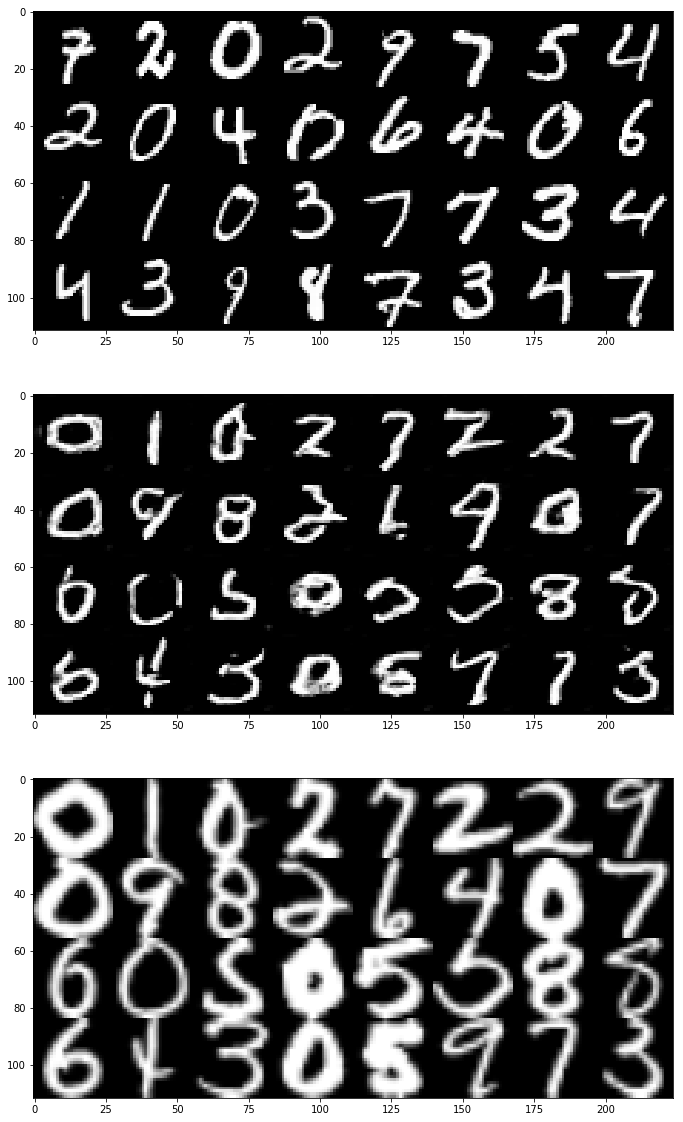

Dest labels:
[7 2 0 2 9 7 5 4 2 0 4 0 6 4 0 6 1 1 0 3 7 7 3 4 4 3 9 8 7 3 4 7]
Source labels:
[0 1 0 2 7 2 2 9 0 9 8 2 6 4 0 7 6 0 5 0 5 5 8 8 6 4 3 0 5 9 7 3]

Epoch 19, Time: 182.01865363121033
epoch 18, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  72.42%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  70.65%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0135 - Loss_D_gen1: 0.0134 - Loss_G1: 0.0188 - Loss_Classifier1: 0.0066 - Loss_Rec1: 0.0074 - Loss_GenClass1: 0.0119

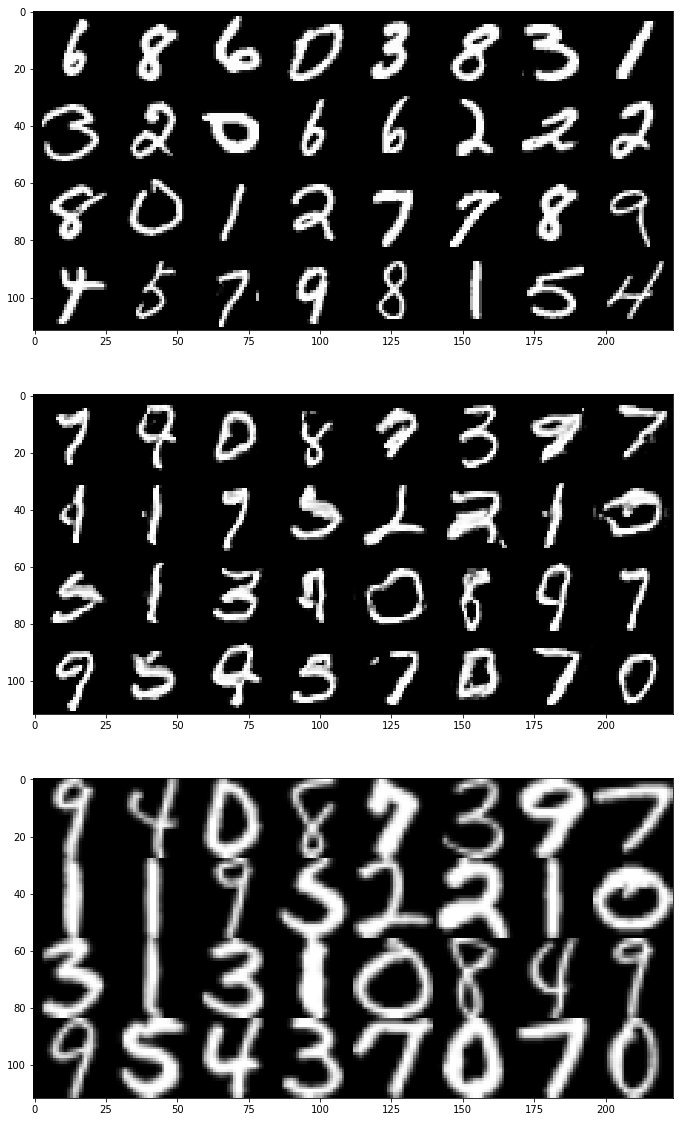

Dest labels:
[6 8 6 0 3 8 3 1 3 2 0 6 6 2 2 2 8 0 1 2 7 7 8 9 4 5 7 9 8 1 5 4]
Source labels:
[9 4 0 8 7 3 9 7 1 1 9 5 2 2 1 0 3 1 3 1 0 8 4 9 9 5 4 3 7 0 7 0]

Epoch 20, Time: 189.4552297592163
epoch 19, Saved weights!
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  74.65%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  73.33%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0134 - Loss_D_gen1: 0.0133 - Loss_G1: 0.0184 - Loss_Classifier1: 0.0066 - Loss_Rec1: 0.0071 - Loss_GenClass1: 0.0111

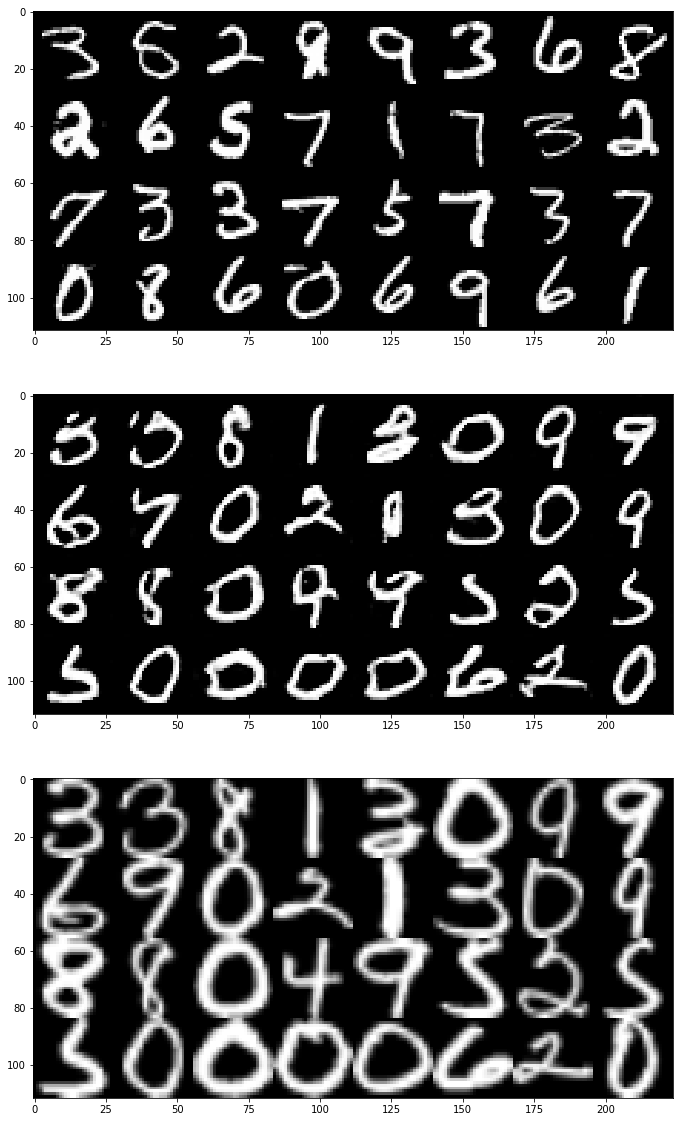

Dest labels:
[3 5 2 8 9 3 6 8 2 6 5 7 1 7 3 2 7 3 3 7 5 7 3 7 0 8 6 0 6 9 6 1]
Source labels:
[3 3 8 1 3 0 9 9 6 9 0 2 1 3 0 9 8 8 0 4 9 5 2 5 5 0 0 0 0 6 2 0]

Epoch 21, Time: 189.16698622703552
epoch 20, Saved weights!
10000/10000 [==============================] - 0s 28us/step

 Classifier Accuracy and loss on full target domain:  73.88%  
10000/10000 [==============================] - 0s 31us/step

 Classifier Accuracy and loss on full target domain:  71.49%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0133 - Loss_D_gen1: 0.0132 - Loss_G1: 0.0180 - Loss_Classifier1: 0.0064 - Loss_Rec1: 0.0068 - Loss_GenClass1: 0.0109

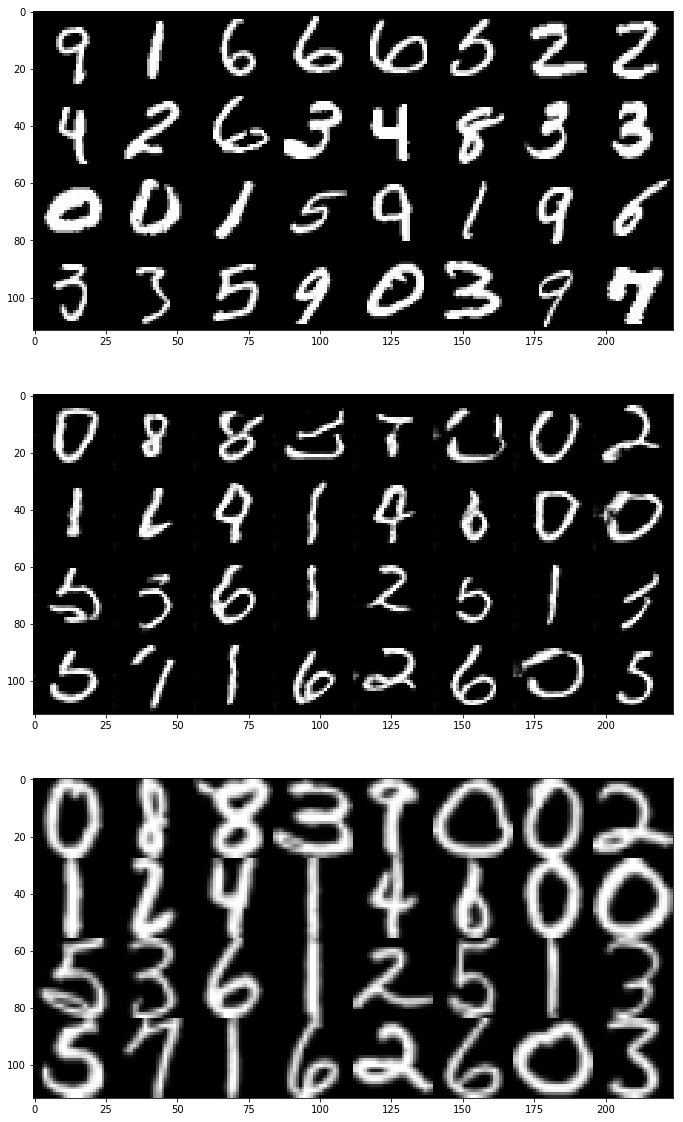

Dest labels:
[9 1 6 6 6 5 2 2 4 2 6 3 4 8 3 3 0 0 1 5 9 1 9 6 3 3 5 9 0 3 9 7]
Source labels:
[0 8 8 3 9 0 0 2 1 2 4 1 4 6 0 0 5 3 6 1 2 5 1 3 5 7 1 6 2 6 0 3]

Epoch 22, Time: 187.8351366519928
epoch 21, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  74.48%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  70.76%  
31936/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0133 - Loss_D_gen1: 0.0132 - Loss_G1: 0.0179 - Loss_Classifier1: 0.0065 - Loss_Rec1: 0.0067 - Loss_GenClass1: 0.0109

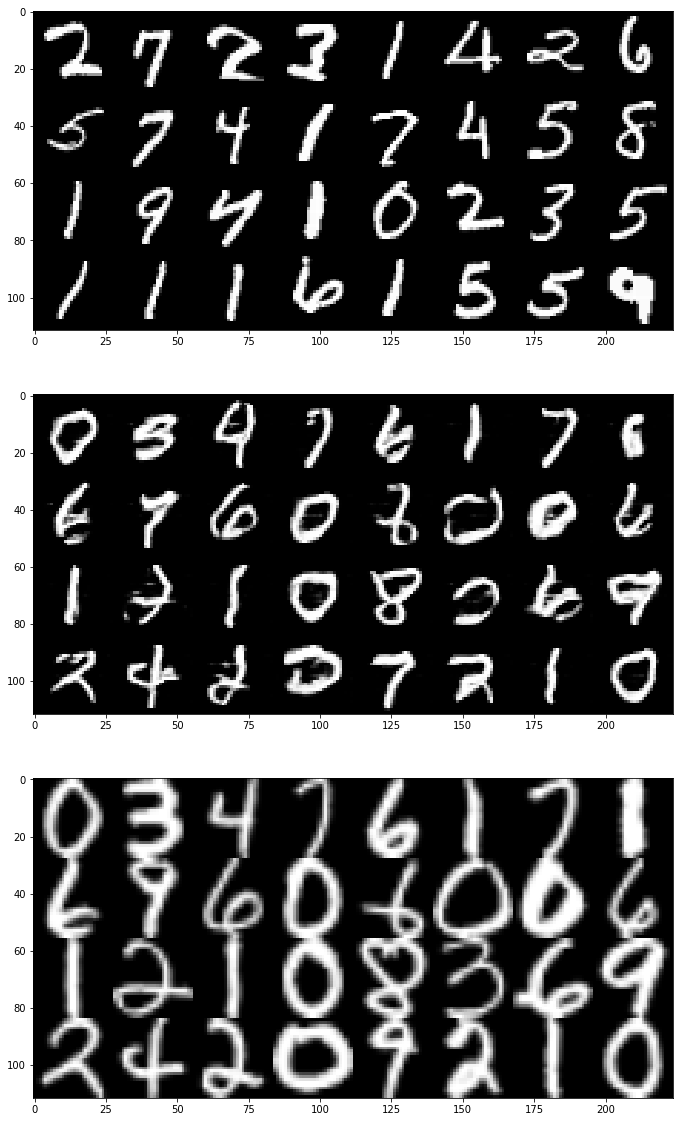

Dest labels:
[2 7 2 3 1 4 2 6 5 7 4 1 7 4 5 8 1 9 4 1 0 2 3 5 1 1 1 6 1 5 5 9]
Source labels:
[0 3 4 7 6 1 7 1 6 9 6 0 6 0 0 6 1 2 1 0 8 3 6 9 2 4 2 0 9 2 1 0]

Epoch 23, Time: 186.86152720451355
epoch 22, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  76.00%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  72.93%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0133 - Loss_D_gen1: 0.0132 - Loss_G1: 0.0174 - Loss_Classifier1: 0.0065 - Loss_Rec1: 0.0068 - Loss_GenClass1: 0.0103

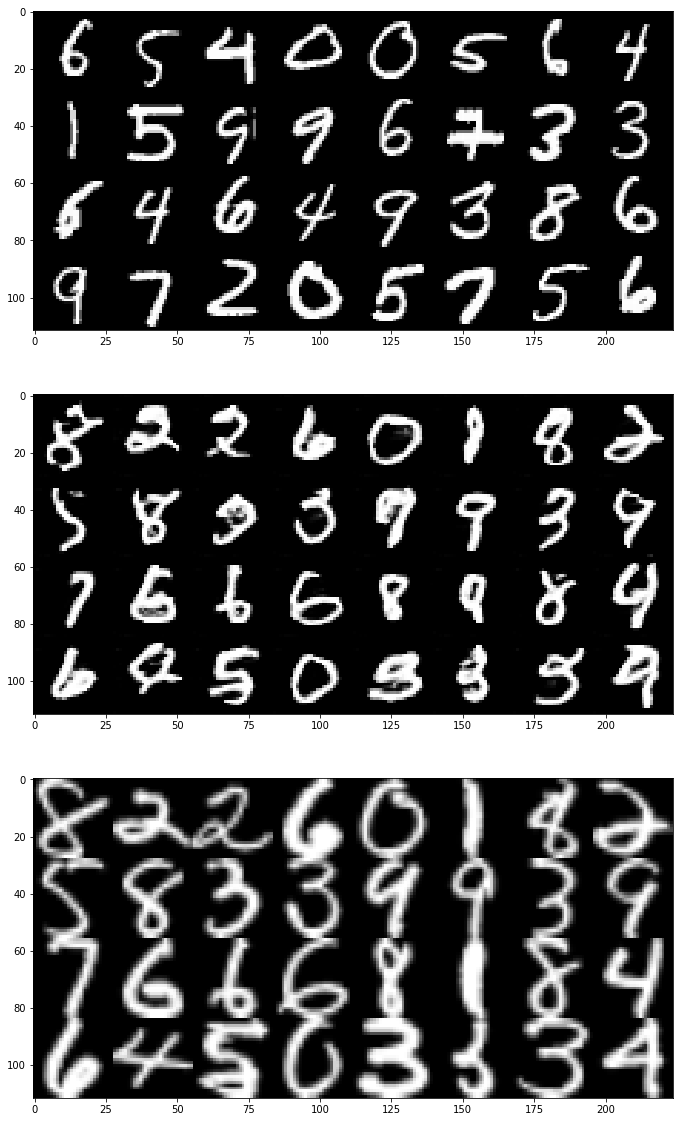

Dest labels:
[6 5 4 0 0 5 6 4 1 5 9 9 6 7 3 3 6 4 6 4 9 3 8 6 9 7 2 0 5 7 5 6]
Source labels:
[8 2 2 6 0 1 8 2 5 8 3 3 9 9 3 9 7 6 6 6 8 1 8 4 6 4 5 0 3 5 3 4]

Epoch 24, Time: 189.011066198349
epoch 23, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  76.12%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  72.59%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0133 - Loss_D_gen1: 0.0131 - Loss_G1: 0.0173 - Loss_Classifier1: 0.0063 - Loss_Rec1: 0.0067 - Loss_GenClass1: 0.0100

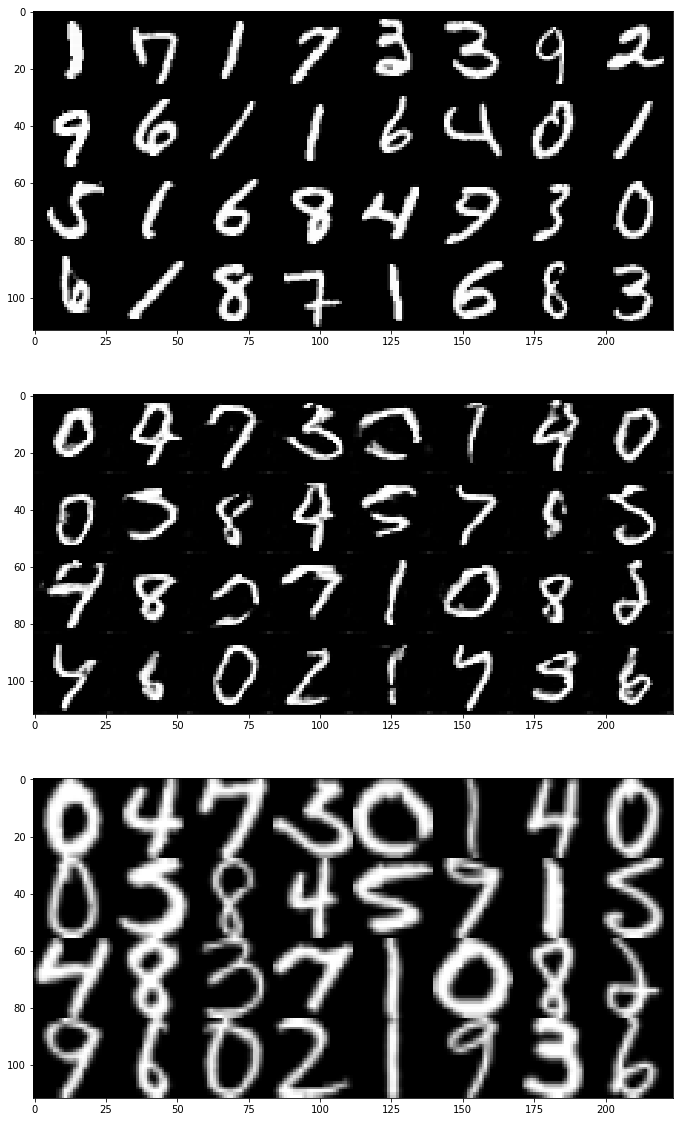

Dest labels:
[1 7 1 7 3 3 9 2 9 6 1 1 6 4 0 1 5 1 6 8 4 9 3 0 6 1 8 7 1 6 8 3]
Source labels:
[0 4 7 5 0 1 4 0 0 5 8 4 5 9 1 5 4 8 3 7 1 0 8 2 9 6 0 2 1 9 3 6]

Epoch 25, Time: 188.12621235847473
epoch 24, Saved weights!
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  74.26%  
10000/10000 [==============================] - 0s 29us/step

 Classifier Accuracy and loss on full target domain:  71.45%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0132 - Loss_D_gen1: 0.0131 - Loss_G1: 0.0171 - Loss_Classifier1: 0.0061 - Loss_Rec1: 0.0068 - Loss_GenClass1: 0.0097

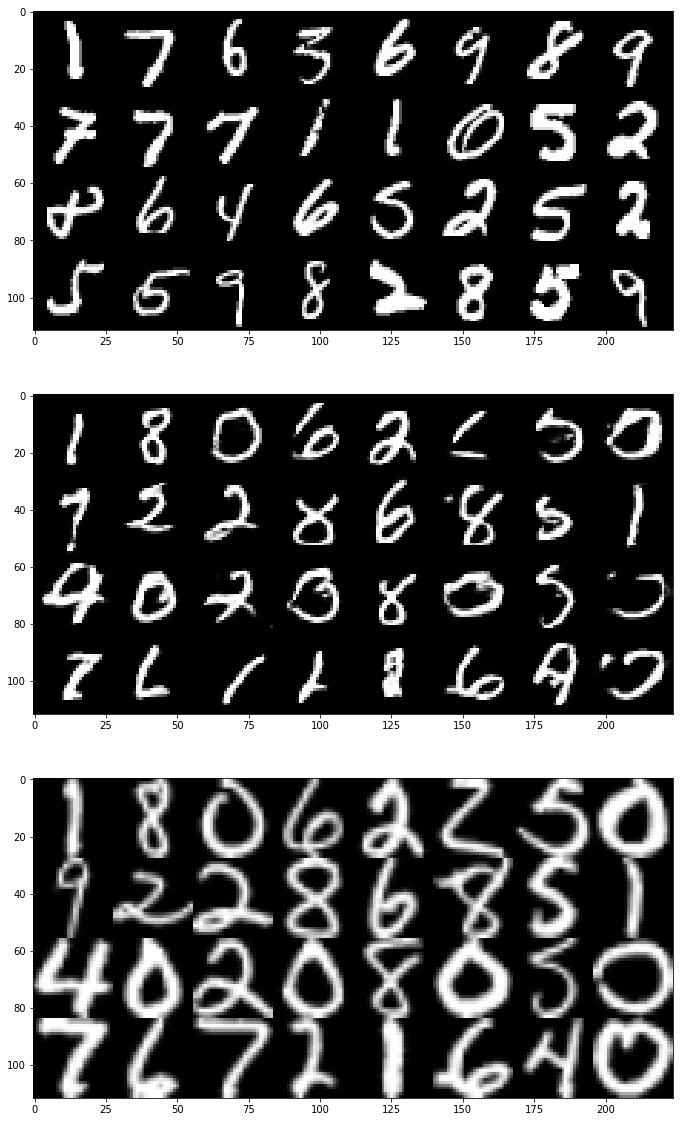

Dest labels:
[1 7 6 3 6 9 8 9 7 7 7 1 1 0 5 2 8 6 4 6 5 2 5 2 5 5 9 8 2 8 5 9]
Source labels:
[1 8 0 6 2 2 5 0 9 2 2 8 6 8 5 1 4 0 2 0 8 0 5 0 7 6 7 2 1 6 4 0]

Epoch 26, Time: 188.549302816391
epoch 25, Saved weights!
10000/10000 [==============================] - 0s 28us/step

 Classifier Accuracy and loss on full target domain:  73.84%  
10000/10000 [==============================] - 0s 30us/step

 Classifier Accuracy and loss on full target domain:  70.93%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0132 - Loss_D_gen1: 0.0131 - Loss_G1: 0.0171 - Loss_Classifier1: 0.0060 - Loss_Rec1: 0.0066 - Loss_GenClass1: 0.0096

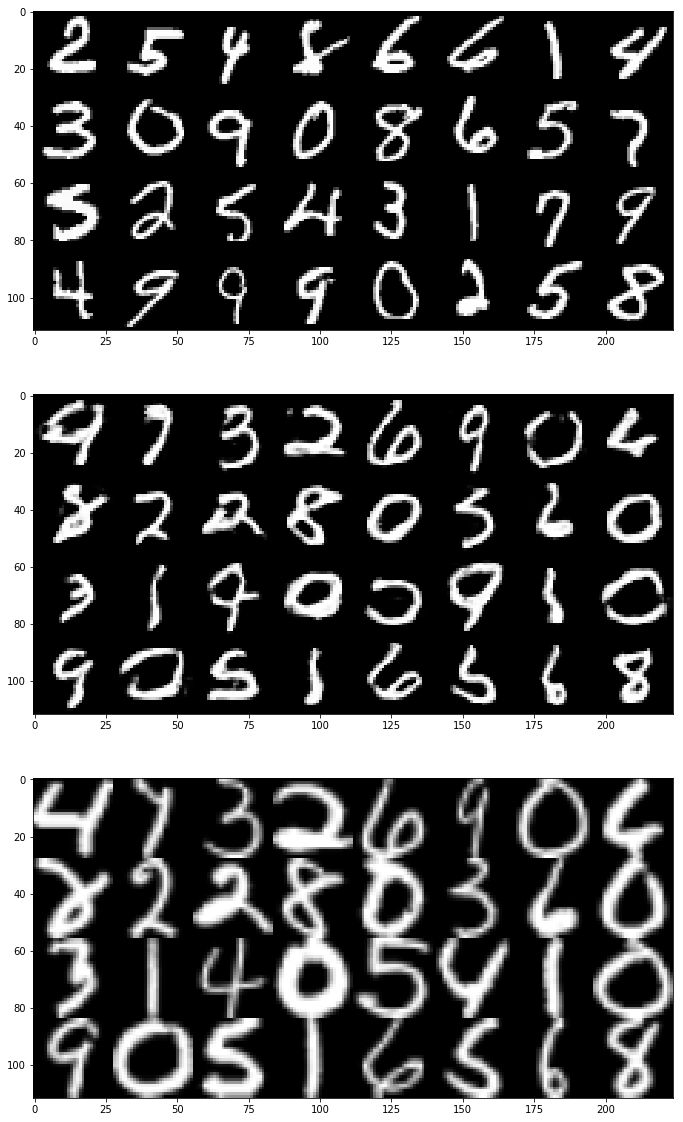

Dest labels:
[2 5 4 8 6 6 1 4 3 0 9 0 8 6 5 7 5 2 5 4 3 1 7 9 4 9 9 9 0 2 5 8]
Source labels:
[4 7 3 2 6 9 0 6 2 2 2 8 0 3 6 0 3 1 4 0 5 4 1 0 9 0 5 1 6 5 6 8]

Epoch 27, Time: 189.42758417129517
epoch 26, Saved weights!
10000/10000 [==============================] - 0s 31us/step

 Classifier Accuracy and loss on full target domain:  72.78%  
10000/10000 [==============================] - 0s 31us/step

 Classifier Accuracy and loss on full target domain:  70.73%  
13344/32000 [===========>..................] - ETA: 1:48 - Loss_D_real1: 0.0132 - Loss_D_gen1: 0.0131 - Loss_G1: 0.0168 - Loss_Classifier1: 0.0059 - Loss_Rec1: 0.0063 - Loss_GenClass1: 0.0091

In [ ]:

# Launch training
train(**d_params)

In [ ]:
import numpy as np
acc = np.load("./accuracy.npy")

In [ ]:
acc.shape

In [ ]:
acc